In [6]:
%pip install --upgrade pip > /dev/null
%pip install matplotlib > /dev/null
%pip install PILLOW > /dev/null
%pip install numpy > /dev/null
%pip install pandas > /dev/null
%pip install torch > /dev/null
%pip install torchvision > /dev/null
%pip install tensorflow > /dev/null

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (20,5)

# ---

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os

In [9]:
train = "dataset/train"
test = "dataset/test"

In [10]:
def get_image_filepaths(class_="apple"):
    return [ fn for fn in os.listdir(f'{train}/{class_}') if fn.endswith( ".jpg" ) ]

# Exploratory data analysis

Let's give our data a closer look, and determine how are individual fruits distributed 

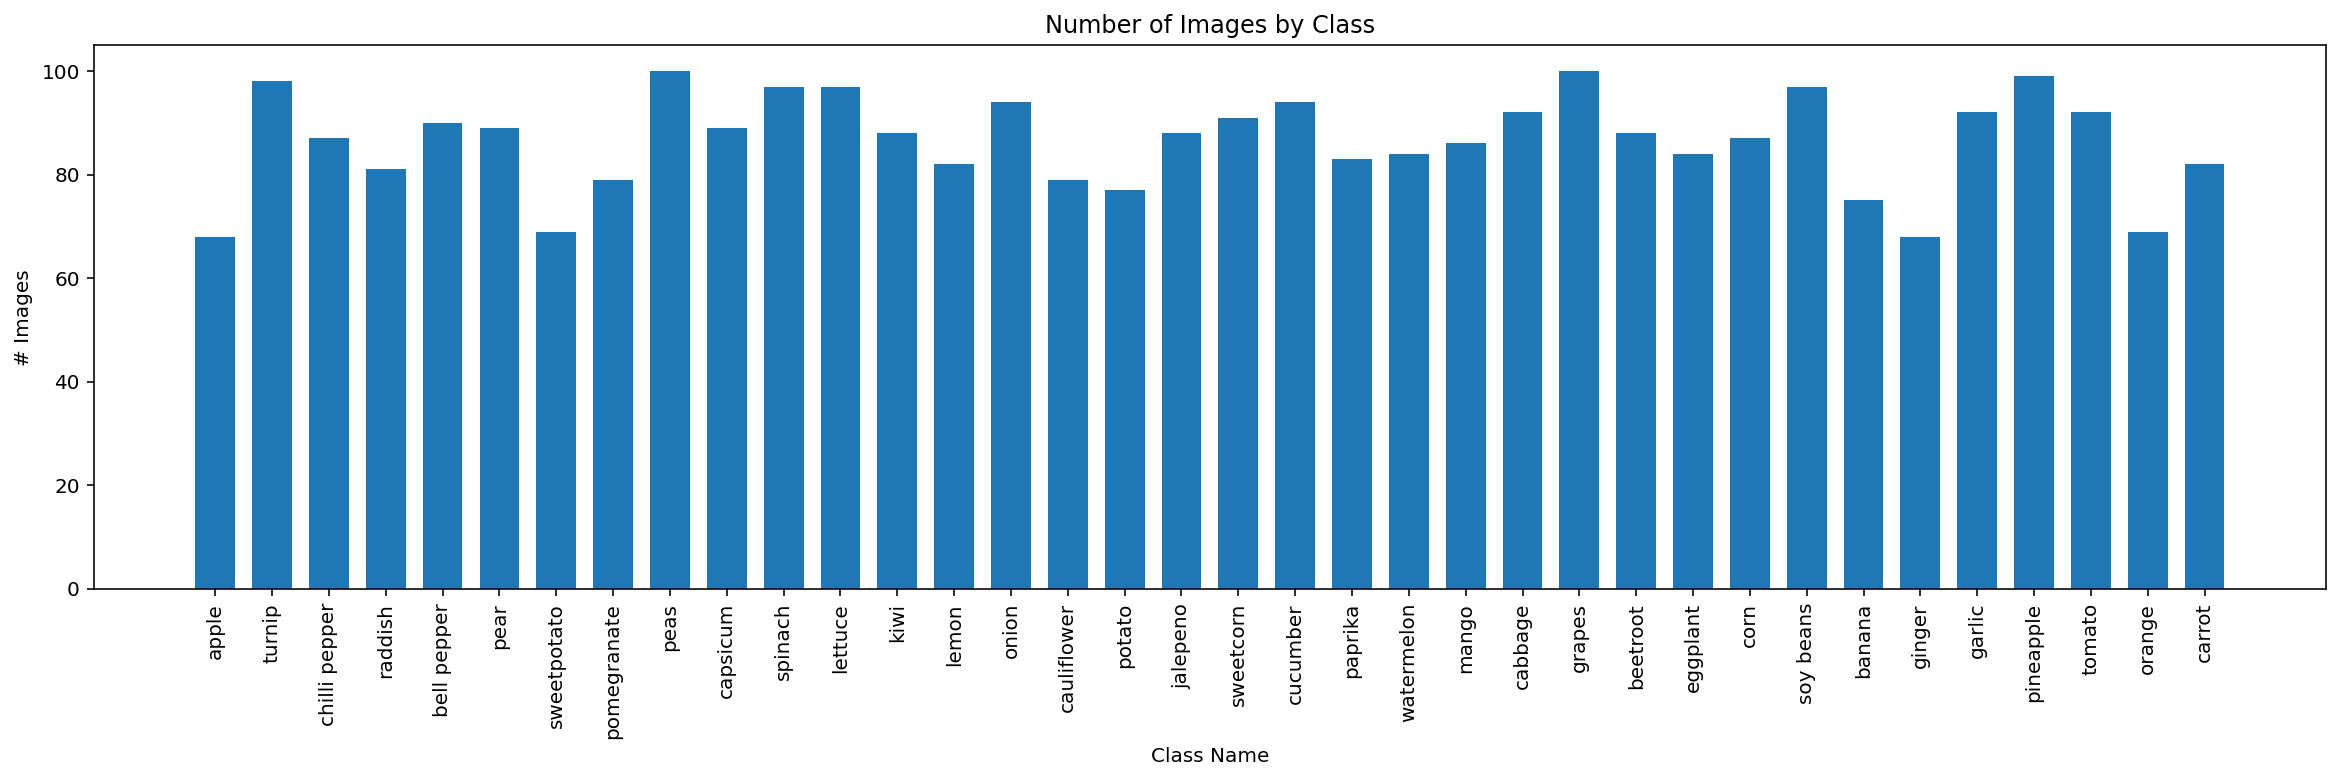

In [11]:
classes = { class_: len( os.listdir( f"{ train }/{ class_ }" ) ) for class_ in os.listdir(train) }

plt.bar(classes.keys(), classes.values(), width = 0.7)
plt.title("Number of Images by Class")
plt.xlabel('Class Name')
plt.xticks(rotation='vertical')
plt.ylabel('# Images');


As we can see, the individual classes are pretty uniformly distributed, there is none that could cause bias in our data (hopefully)

Function `disp_class` allows us to display `n` random samples of given class, so lets look at few apples

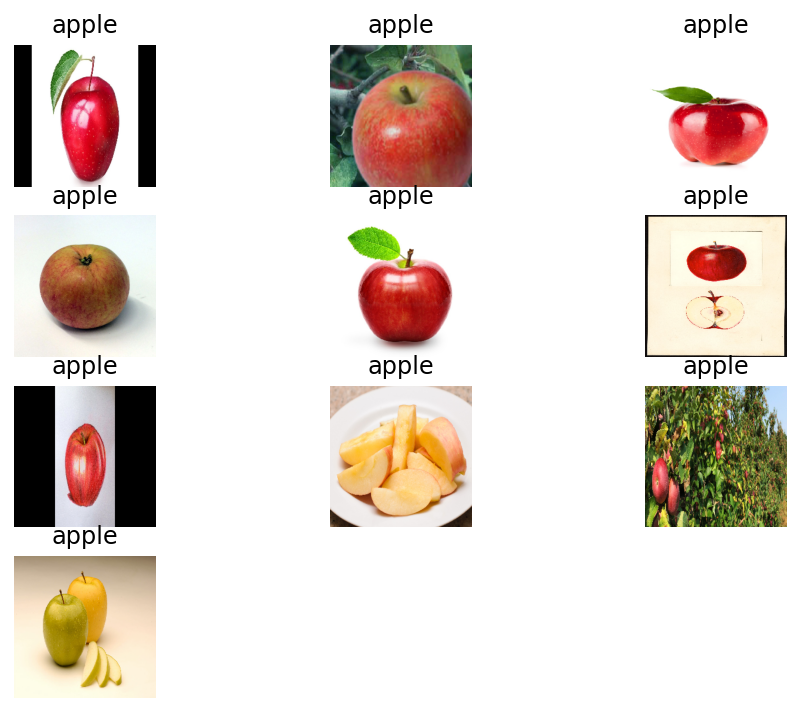

In [12]:
from tensorflow.keras.preprocessing import image

def disp_class( n_samples=10, class_="apple" ):
    images = get_image_filepaths( class_ )
    
    n_samples = min( n_samples, len( images ) )

    select = np.random.choice( images, n_samples, replace=False )
    fig = plt.figure( figsize=( 8, 6 ) )

    for i in range( len( select ) ):
        fp = f'{ train }/{ class_ }/{ select[ i ] }'
        ax = fig.add_subplot( n_samples // 3 + 1 , 3, i+1 )

        fn = image.load_img( fp, target_size=( 256, 256 ) )
        plt.imshow( fn )
        plt.title( class_ )
        plt.axis( 'off' )

    plt.show()
    
disp_class( 10, "apple" )


As can be seen, all apples in out training dataset are red, this might cause quite poor performance on real-world data, as apples are quite ofter green or yellow

In [59]:
def img2np(path, list_of_filename, size = (64, 64)):
    for fn in list_of_filename:
        fp = path + fn
        # current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')
        current_image = image.load_img(fp, target_size = size, color_mode = 'grayscale')

        img_ts = image.img_to_array(current_image)

        img_ts = [img_ts.ravel()]
        try:
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            full_mat = img_ts
    return full_mat

def find_img_stat( matrix, class_, title, shape=( 64, 64 ), f=np.mean, **f_kwargs ):
    img = f( matrix, **f_kwargs )
    img = img.reshape( shape )
    plt.imshow( img, vmin=0, vmax=255,  )
    plt.title( title )
    plt.axis( "off" )
    plt.show()
    return img

Now lets look at more interesting statistics about our dataset, we created a function which turns an image into matrix and then compute desired result using some `numpy` function

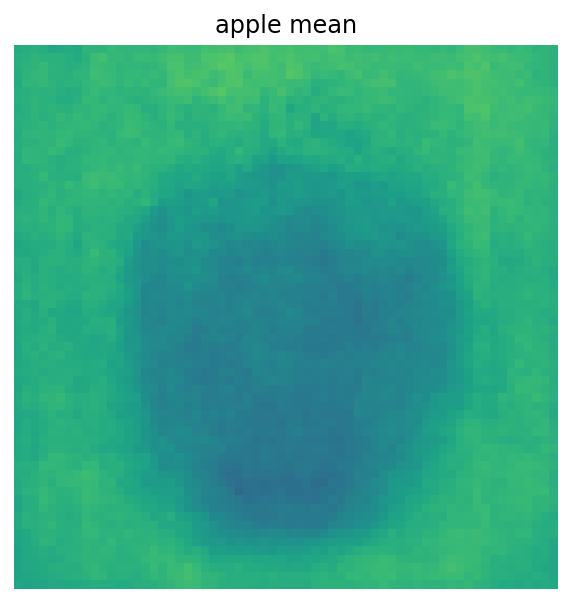

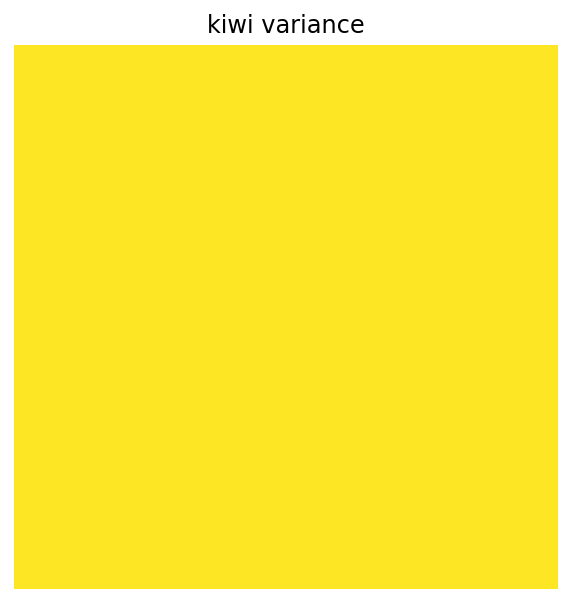

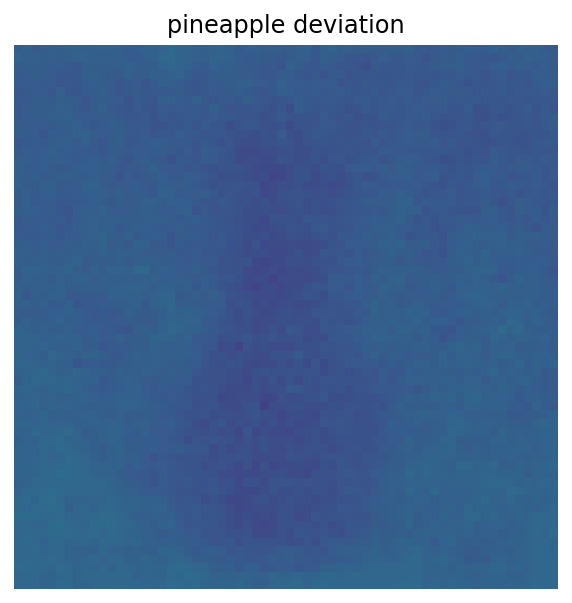

In [78]:
apple_images = img2np(f'{train}/apple/', get_image_filepaths( "apple" ) )
kiwi_images = img2np(f'{train}/kiwi/', get_image_filepaths( "kiwi" ) )
pineapple_images = img2np(f'{train}/pineapple/', get_image_filepaths( "pineapple" ) )

apple_mean = find_img_stat( apple_images, "apple", "apple mean", f=np.mean, axis=0 )
kiwi_var = find_img_stat( kiwi_images, "kiwi", "kiwi variance", f=np.var, axis=0 )
pineapple_dev = find_img_stat( pineapple_images, "pineapple", "pineapple deviation", f=np.std, axis=0 )

Last but not least, we will use PCA to find componensts, which describe each class the best

In [ ]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages( matrix, n_components = 0.3, size = (64, 64)):
    pca = PCA( n_components=n_components, whiten=True )
    pca.fit( matrix )
    return pca
  
def plot_pca(pca, title, size = (64, 64)):
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    
    r = int(n ** 0.5)
    c = ceil( n / r)
    
    for i in range(n):
        ax = fig.add_subplot( r, c, i + 1, xticks=[], yticks=[] )
        ax.imshow( pca.components_[i].reshape(size) )
        plt.title( f"{ title }: { i + 1 }" )
    plt.axis( "off" )
    plt.show()
    
plot_pca(eigenimages(apple_images), "apple" )
plot_pca(eigenimages(kiwi_images), "kiwi" )


# Data Preparation

In [8]:
train_transforms = transforms.Compose([
    transforms.Resize( 256 ),
    transforms.CenterCrop( 224 ),
    transforms.ToTensor(),
    transforms.Normalize( mean=[ 0.485, 0.456, 0.406 ], std=[ 0.229, 0.224, 0.225 ] ),
])

test_transforms = transforms.Compose([
    transforms.Resize( 256 ),
    transforms.CenterCrop( 224 ),
    transforms.ToTensor(),
    transforms.Normalize( mean=[ 0.485, 0.456, 0.406 ], std=[ 0.229, 0.224, 0.225 ] ),
])

train_data = datasets.ImageFolder( train, transform=train_transforms )
test_data = datasets.ImageFolder( test, transform=test_transforms )
    
trainloader = torch.utils.data.DataLoader( train_data, batch_size=64 )
testloader = torch.utils.data.DataLoader( test_data, batch_size=64 )

# trainloader.dataset.classes

# Model specification

In [ ]:
# lets abuse GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = models.resnet18(pretrained=True)

In [6]:
# for param in model.parameters():
#     param.requires_grad = False
#     
# model.fc = nn.Sequential(nn.Linear(2048, 512),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 10),
#                                  nn.LogSoftmax(dim=1))
# criterion = nn.NLLLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
# model.to(device)
model = torch.hub.load( "pytorch/vision:v0.10.0", "resnet18", pretrained=True )

Using cache found in /Users/krebso/.cache/torch/hub/pytorch_vision_v0.10.0


# Model Training

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range( epochs ):
    for inputs, labels in trainloader:
        steps += 1
        
        inputs, labels = inputs.to( device ), labels.to( device )
        
        optimizer.zero_grad()
        
        logps = model.forward( inputs )
        
        loss = criterion( logps, labels )
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to( device ), labels.to( device )
                    logps = model.forward( inputs )
                    
                    batch_loss = criterion( logps, labels )
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view( *top_class.shape )
                    accuracy += torch.mean( equals.type( torch.FloatTensor) ).item()
            
            train_losses.append( running_loss / len(trainloader) )
            test_losses.append( test_loss / len(testloader) )                    
            
            print(f"Epoch { epoch + 1 }/{ epochs }.. "
                  f"Train loss: { running_loss / print_every:.3f }.. "
                  f"Test loss: { test_loss / len( testloader ):.3f }.. "
                  f"Test accuracy: { accuracy / len( testloader ):.3f }")
            
            running_loss = 0
            model.train()

torch.save( model, "model.pth" )

Epoch 1/1.. Train loss: 0.605.. Test loss: 0.681.. Test accuracy: 0.004
Epoch 1/1.. Train loss: 0.596.. Test loss: 1.216.. Test accuracy: 0.000


# Model Evaluation

In [ ]:
# TBD